In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.layers import Dense,Flatten,Input
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.utils.data_utils import get_file
from keras.initializers import he_normal
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG19 

In [2]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#onehot 
y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

# data preprocessing 使用rbg均質
x_train[:, :, :, 0] = (x_train[:, :, :, 0]-123.680)
x_train[:, :, :, 1] = (x_train[:, :, :, 1]-116.779)
x_train[:, :, :, 2] = (x_train[:, :, :, 2]-103.939)
x_test[:, :, :, 0] = (x_test[:, :, :, 0]-123.680)
x_test[:, :, :, 1] = (x_test[:, :, :, 1]-116.779)
x_test[:, :, :, 2] = (x_test[:, :, :, 2]-103.939)


In [4]:
#放大圖片
def resize_img(img):
    numberOfImage = img.shape[0]
    new_array = np.zeros((numberOfImage, 150,150,3))
    for i in range(numberOfImage):
        new_array[i] = cv2.resize(img[i,:,:,:],(150,150))
    return new_array

x_train = resize_img(x_train)
x_test = resize_img(x_test)


In [5]:
vgg = VGG19(include_top=False,input_shape=(150,150,3),weights=None)

vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [6]:
model = Sequential()

for layer in vgg.layers:
    model.add(layer)
    
# for layer in model.layers:
#     layer.trainable = False
    
# model modification for cifar-10
model.add(Flatten(name='flatten'))
model.add(Dense(4096,name='fc_cifa10'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4096,kernel_initializer=he_normal(),name='fc2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, name='predictions_cifa10'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

In [7]:
model.compile(optimizer="RMSprop",loss="categorical_crossentropy",metrics=["accuracy"])
hist = model.fit(x_train,y_train,validation_data=(x_train,y_train),validation_split=0.15,epochs=10,batch_size=100,verbose=2)

Epoch 1/10
500/500 - 113s - loss: 1.8109 - accuracy: 0.3472 - val_loss: 1.5957 - val_accuracy: 0.4368 - 113s/epoch - 226ms/step
Epoch 2/10
500/500 - 75s - loss: 1.5042 - accuracy: 0.4655 - val_loss: 1.4353 - val_accuracy: 0.4847 - 75s/epoch - 149ms/step
Epoch 3/10
500/500 - 75s - loss: 1.3120 - accuracy: 0.5423 - val_loss: 1.2583 - val_accuracy: 0.5580 - 75s/epoch - 150ms/step
Epoch 4/10
500/500 - 75s - loss: 1.1688 - accuracy: 0.5916 - val_loss: 1.0340 - val_accuracy: 0.6416 - 75s/epoch - 149ms/step
Epoch 5/10
500/500 - 75s - loss: 1.0275 - accuracy: 0.6468 - val_loss: 0.8932 - val_accuracy: 0.6928 - 75s/epoch - 149ms/step
Epoch 6/10
500/500 - 75s - loss: 0.8808 - accuracy: 0.6987 - val_loss: 0.8229 - val_accuracy: 0.7157 - 75s/epoch - 149ms/step
Epoch 7/10
500/500 - 75s - loss: 0.7275 - accuracy: 0.7556 - val_loss: 0.6207 - val_accuracy: 0.7914 - 75s/epoch - 150ms/step
Epoch 8/10
500/500 - 75s - loss: 0.5680 - accuracy: 0.8146 - val_loss: 0.3963 - val_accuracy: 0.8821 - 75s/epoch - 1

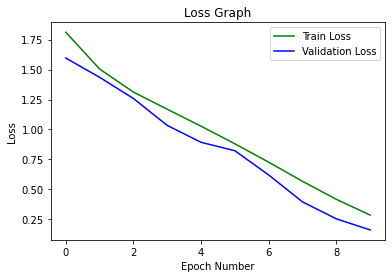

In [8]:
plt.subplots(figsize=(6,4))
plt.plot(hist.epoch,hist.history["loss"],color="green",label="Train Loss")
plt.plot(hist.epoch,hist.history["val_loss"],color="blue",label="Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()

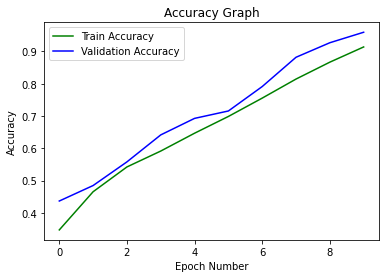

In [9]:
plt.subplots(figsize=(6,4))
plt.plot(hist.epoch,hist.history["accuracy"],color="green",label="Train Accuracy")
plt.plot(hist.epoch,hist.history["val_accuracy"],color="blue",label="Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Graph")
plt.show()